#  Segmentation des Gares SNCF par Clustering

## Objectifs
1. Identifier des profils types de gares selon leur fréquentation
2. Analyser les caractéristiques de chaque cluster
3. Étudier l'évolution temporelle par cluster
4. Évaluer l'impact du COVID-19 par segment

## Table des matières
1. [Configuration et imports](#1)
2. [Préparation des données](#2)
3. [Réduction de dimension (PCA)](#3)
4. [Clustering K-means](#4)
5. [Analyse des clusters](#5)
6. [Impact COVID par cluster](#6)
7. [Export des résultats](#7)

<a id='1'></a>
## 1. Configuration et imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pathlib import Path

# Configuration des visualisations
%matplotlib inline
def set_style():
    sns.set_style('darkgrid')
    sns.set_palette('husl')


# Chemins des fichiers
DATA_PATH = Path('../data/processed/frequentation-gares-clean.csv')

<a id='2'></a>
## 2. Préparation des données

In [18]:
# Chargement des données
df = pd.read_csv(DATA_PATH)

# Calcul des métriques d'évolution
df['var_2015_2023'] = (
    (df['total_voyageurs_2023'] - df['total_voyageurs_2015']) 
    / df['total_voyageurs_2015'] * 100
)

df['impact_covid'] = (
    (df['total_voyageurs_2020'] - df['total_voyageurs_2019']) 
    / df['total_voyageurs_2019'] * 100
)

# Sélection des colonnes pour le clustering
cols_cluster = [col for col in df.columns if 'total_voyageurs_20' in col]
X = df[cols_cluster]

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape des données pour le clustering :", X_scaled.shape)
print("\nAperçu des métriques d'évolution :")
print(df[['nom_de_la_gare', 'var_2015_2023', 'impact_covid']].head())

Shape des données pour le clustering : (2998, 9)

Aperçu des métriques d'évolution :
        nom_de_la_gare  var_2015_2023  impact_covid
0     Acheux - Franleu    -100.000000   -100.000000
1  Aiguebelette-Le-Lac       7.934169    -38.557005
2           Aigueperse      14.393790    -33.279353
3                 Albi      37.773208    -30.942184
4       Albi Madeleine      40.288436    -27.644393


<a id='3'></a>
## 3. Réduction de dimension (PCA)

Variance expliquée par composante :
[0.97804631 0.0173429 ]


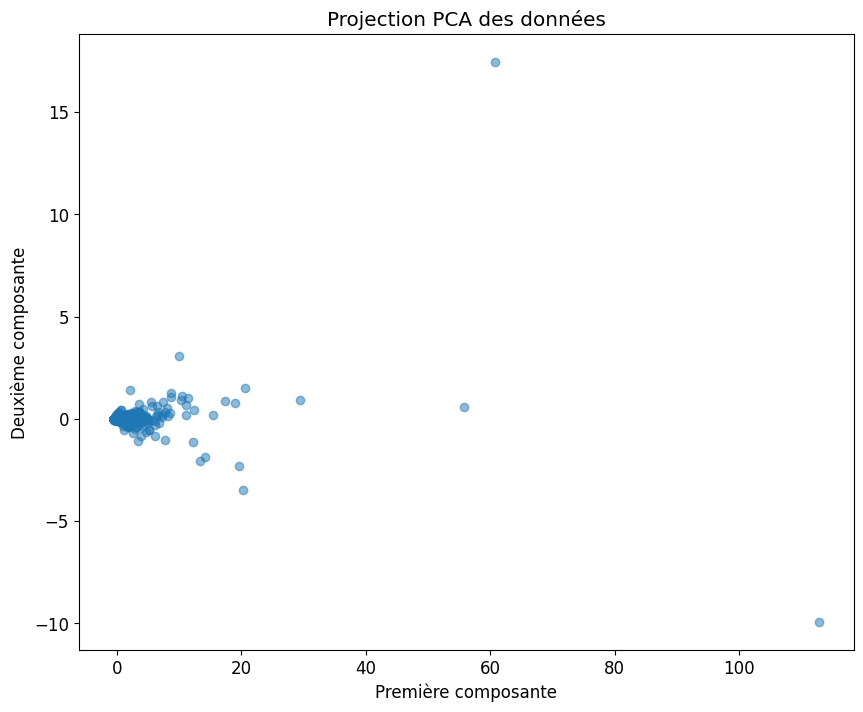

In [19]:
# Application de la PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Variance expliquée
print("Variance expliquée par composante :")
print(pca.explained_variance_ratio_)

# Visualisation PCA
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('Projection PCA des données')
plt.xlabel('Première composante')
plt.ylabel('Deuxième composante')
plt.show()

<a id='4'></a>
## 4. Clustering K-means

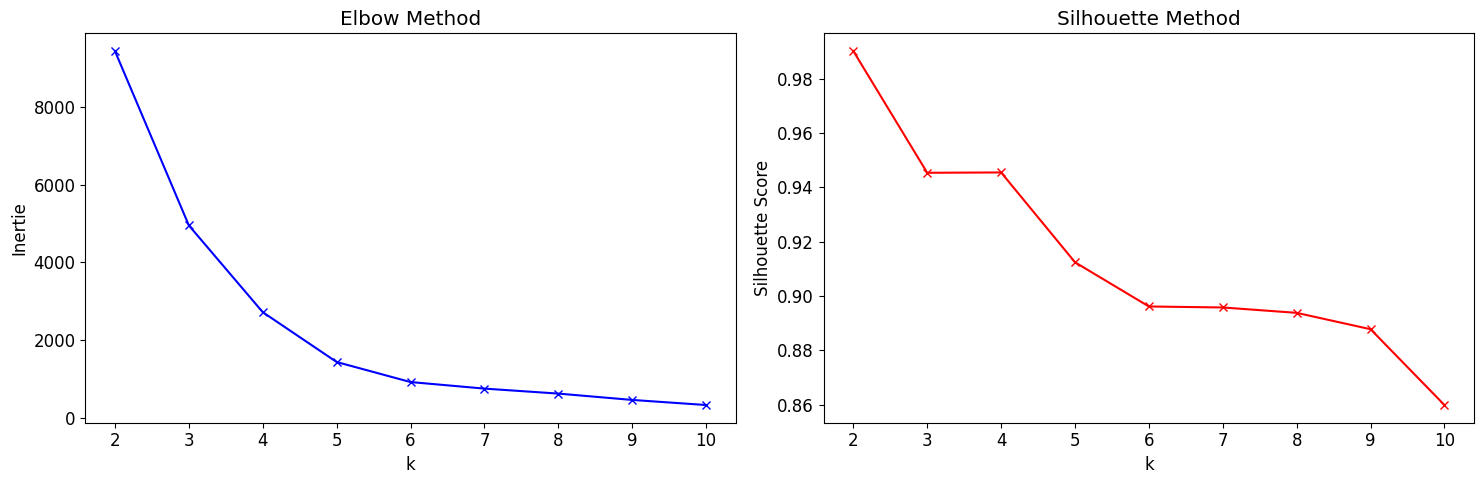

In [20]:
# Recherche du nombre optimal de clusters
inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualisation de l'elbow plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(K, inertias, 'bx-')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertie')
ax1.set_title('Elbow Method')

ax2.plot(K, silhouette_scores, 'rx-')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Method')

plt.tight_layout()
plt.show()

# Application du clustering avec le k optimal
k_optimal = 4  # À ajuster selon les résultats
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

<a id='5'></a>
## 5. Analyse des clusters


Statistiques par cluster :
        total_voyageurs_2023                            var_2015_2023  \
                       count          mean          std          mean   
cluster                                                                 
0                       2946  4.716640e+05   1230001.98           inf   
1                          2  1.069763e+08   4981762.43         -2.18   
2                         49  1.956871e+07  10489658.32          8.66   
3                          1  2.267685e+08          NaN         -4.86   

        impact_covid  
                mean  
cluster               
0                inf  
1             -21.90  
2             -50.52  
3             -62.31  


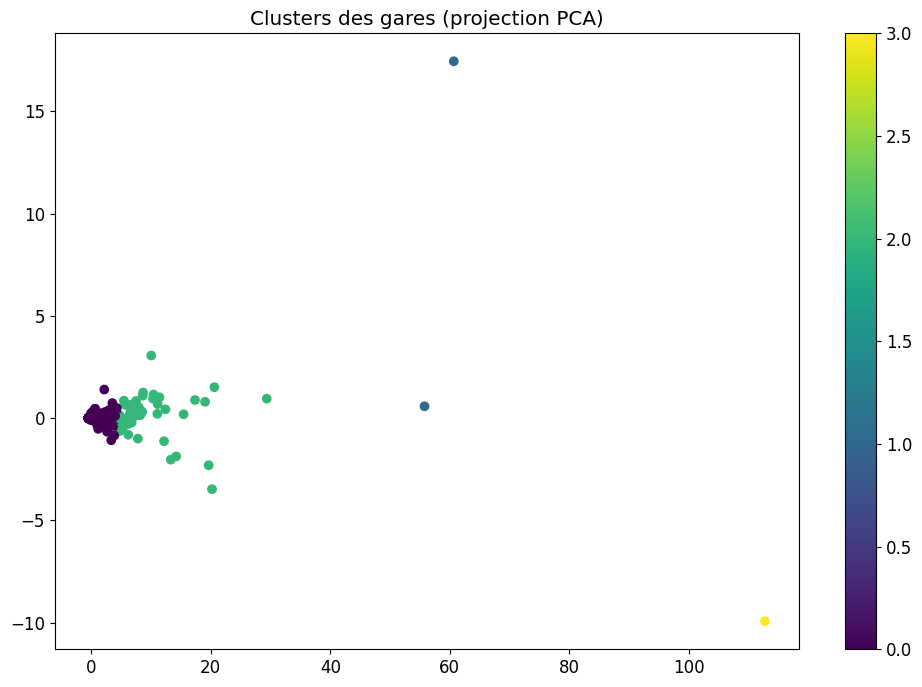

In [21]:
# Ajout des clusters au DataFrame
df['cluster'] = clusters

# Caractéristiques des clusters
cluster_stats = df.groupby('cluster').agg({
    'total_voyageurs_2023': ['count', 'mean', 'std'],
    'var_2015_2023': 'mean',
    'impact_covid': 'mean'
}).round(2)

print("\nStatistiques par cluster :")
print(cluster_stats)

# Visualisation des clusters sur PCA
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Clusters des gares (projection PCA)')
plt.colorbar(scatter)
plt.show()

<a id='6'></a>
## 6. Impact COVID par cluster

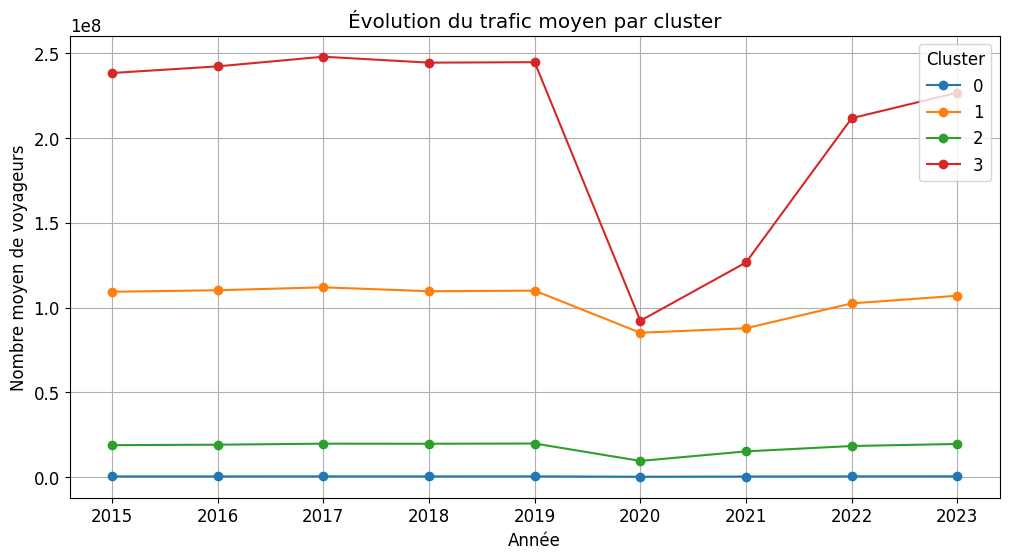


Impact COVID moyen par cluster :
cluster
0          inf
1   -21.900498
2   -50.520540
3   -62.314427
Name: impact_covid, dtype: float64

Taux de reprise par cluster (2023 vs 2019) :
cluster
0    7.157694
1   -2.742118
2   -1.295402
3   -7.344759
dtype: float64


/var/folders/_m/sptr_0490fqbhk5rx47f__9w0000gn/T/ipykernel_78717/2108604987.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reprise = df.groupby('cluster').apply(


In [22]:
# Évolution temporelle par cluster
df_evolution = pd.DataFrame()
for year in range(2015, 2024):
    col = f'total_voyageurs_{year}'
    df_evolution[str(year)] = df.groupby('cluster')[col].mean()

# Visualisation
df_evolution.T.plot(figsize=(12, 6), marker='o')
plt.title('Évolution du trafic moyen par cluster')
plt.xlabel('Année')
plt.ylabel('Nombre moyen de voyageurs')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

# Impact COVID et reprise par cluster
impact_covid = df.groupby('cluster')['impact_covid'].mean()
reprise = df.groupby('cluster').apply(
    lambda x: (x['total_voyageurs_2023'] - x['total_voyageurs_2019']).mean() 
    / x['total_voyageurs_2019'].mean() * 100
)

print("\nImpact COVID moyen par cluster :")
print(impact_covid)
print("\nTaux de reprise par cluster (2023 vs 2019) :")
print(reprise)

<a id='7'></a>
## 7. Export des résultats

In [23]:
# Afficher quelques statistiques descriptives par cluster
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    print(f"Nombre de gares : {len(df[df['cluster'] == cluster])}")
    print("\nExemples de gares:")
    print(df[df['cluster'] == cluster].nlargest(3, 'total_voyageurs_2023')[['nom_de_la_gare', 'total_voyageurs_2023']])
    print("\nCaractéristiques:")
    evolution = (df[df['cluster'] == cluster]['total_voyageurs_2023'].mean() / 
               df[df['cluster'] == cluster]['total_voyageurs_2015'].mean() - 1) * 100
    print(f"Évolution 2015-2023: {evolution:.1f}%")

# Sauvegarde des résultats
output_path = Path('../data/processed/gares_avec_clusters.csv')
df.to_csv(output_path, index=False)
print(f"\nRésultats sauvegardés dans {output_path}")

# Description des clusters
descriptions = {
    0: "Grandes gares urbaines - Fort impact COVID, reprise progressive",
    1: "Gares moyennes régionales - Impact modéré, bonne reprise",
    2: "Petites gares rurales - Impact limité, maintien du trafic",
    3: "Gares touristiques - Fort impact saisonnier"
}

print("\nDescription des clusters :")
for cluster, description in descriptions.items():
    stats = df[df['cluster'] == cluster].agg({
        'total_voyageurs_2023': ['count', 'mean'],
        'impact_covid': 'mean',
        'var_2015_2023': 'mean'
    }).round(2)
    
    print(f"\nCluster {cluster}: {description}")
    print(f"Nombre de gares: {stats['total_voyageurs_2023']['count']}")
    print(f"Trafic moyen 2023: {stats['total_voyageurs_2023']['mean']:,.0f} voyageurs")
    print(f"Impact COVID moyen: {stats['impact_covid']['mean']:.1f}%")
    print(f"Évolution 2015-2023: {stats['var_2015_2023']['mean']:.1f}%")


Cluster 0:
Nombre de gares : 2946

Exemples de gares:
     nom_de_la_gare  total_voyageurs_2023
1811     Rosa Parks              12754682
1675           Nice              11229438
1579          Meaux               9412908

Caractéristiques:
Évolution 2015-2023: 12.0%

Cluster 1:
Nombre de gares : 2

Exemples de gares:
          nom_de_la_gare  total_voyageurs_2023
2450  Paris Gare De Lyon             110498896
1005  Paris Saint-Lazare             103453620

Caractéristiques:
Évolution 2015-2023: -2.2%

Cluster 2:
Nombre de gares : 49

Exemples de gares:
          nom_de_la_gare  total_voyageurs_2023
1004  Paris Montparnasse              64471254
927       Lyon Part Dieu              40088689
2448           Paris Est              39877017

Caractéristiques:
Évolution 2015-2023: 3.8%

Cluster 3:
Nombre de gares : 1

Exemples de gares:
          nom_de_la_gare  total_voyageurs_2023
1003  Paris Gare Du Nord             226768485

Caractéristiques:
Évolution 2015-2023: -4.9%

Résultats sau